# Prédictions Energie

Maintenant qu'on a préparé notre dataset et nos variables lors d'une première partie, on va pouvoir passer à l'objectif de ce projet, c'est-à-dire la prédiction des valeurs de consommation énergétique et d'émission de CO2. Dans ce notebook, on se concentrera sur la variable de consommation d'énergie, SiteEnergyUseWN(kBtu) qu'on a sélectionnée précédemment.

In [1]:
#On importe les librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#Pour le parameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate

#Pour les modèles
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
from sklearn.model_selection import train_test_split

from warnings import filterwarnings
filterwarnings('ignore')

## Choix du modèle 

### Première approche simple

Pour commencer, il va falloir chercher quel modèle nous allons utiliser pour faire nos prédictions. Pour cela, nous allons en tester plusieurs puis on comparera leurs résultats sur une première itération sans modifier les paramètres par défaut. On sélectionnera ainsi les meilleurs modèles, qu'on essayera par la suite d'améliorer en modifiant leurs hyperparamètres. Commençons donc par appliquer divers modèles d'apprentissage afin de trouver les plus performants sur notre problème.

Avant de commencer, on va devoir séparer notre dataset en train/test afin de tester les performances.

In [2]:
#On importe nos données
ml_data = pd.read_csv('ml_data_prop.csv')
ml_data

,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,BuildingType_Campus,BuildingType_Nonresidential WA,PrimaryPropertyType_Hotel,PrimaryPropertyType_Other,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_University,PrimaryPropertyType_Small- and Mid-Sized Office,...,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,1.239631,-0.117179,-0.316166,60.0,7.456910e+06,0.277302,0.546060,0.176638,249.98
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,1.081338,-0.033973,0.026583,61.0,8.664479e+06,0.000000,0.386609,0.613391,295.86
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,5.830126,4.653877,4.159728,43.0,7.393711e+07,0.297113,0.682307,0.020579,2089.28
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,0.923045,-0.266269,-0.316166,56.0,6.946800e+06,0.325913,0.407519,0.266567,286.43
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.073822,2.189389,0.362008,1.094510,75.0,1.465650e+07,0.000000,0.378802,0.621198,505.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.073822,-0.501591,-0.503036,-0.316166,NaN,1.025432e+06,0.000000,0.678440,0.321560,20.33
1513,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.073822,-0.501591,-0.515469,-0.316166,NaN,1.053706e+06,0.000000,0.417296,0.582704,32.17
1514,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.073822,-0.501591,-0.531101,-0.316166,NaN,6.053764e+06,0.000000,0.310820,0.689180,223.54
1515,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.073822,-0.501591,-0.525911,-0.316166,NaN,7.828413e+05,0.000000,0.484898,0.515102,22.11


In [3]:
#On retire le ENERGYSTARScore dont on ne va pas se préoccuper pour l'instant. 
#On retire aussi la variable d'émissions dont on se servira dans un autre notebook.
energy_data = ml_data.drop(['ENERGYSTARScore','TotalGHGEmissions'], axis=1)

Les données de consommation énergétique sont assez variées, on aimerait donc s'assurer de la bonne répartition de nos valeurs sur la séparation train/test, ainsi que lors de la cross validation par la suite. Cependant, on a affaire à des valeurs numériques continues, donc on ne peut pas appliquer directement un StratifiedKFold. On va donc d'abord répartir nos valeurs dans des groupes de quantiles, afin de les séparer.

In [4]:
discret = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile',random_state=10)
energy_data['Bins'] = discret.fit_transform(np.array(energy_data['SiteEnergyUseWN(kBtu)']).reshape(-1,1))

In [5]:
#On sépare les colonnes pour isoler la variable cible
y, X = energy_data['SiteEnergyUseWN(kBtu)'], energy_data.drop(columns={'SiteEnergyUseWN(kBtu)'})

#On sépare en train et test, avec stratification sur les bins
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10,stratify=energy_data['Bins'])

#On sépare le train une nouvelle fois pour comparer les modèles
X_compare, X_validate, y_compare, y_validate = train_test_split(X_train, y_train, test_size=0.3, random_state=10, stratify=X_train['Bins'])

Maintenant qu'on a séparé nos données, on va faire une nouvelle discrétisation à  partir des bins pour créer des folds, avec la fonction StratifiedKFold qu'on va pouvoir appliquer directement sur la variable 'Bins' car elle n'est pas continue.

In [6]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i, (train, test) in enumerate(skf.split(X_train,X_train['Bins'])):
     X_train.loc[test, 'Fold'] = i

On obtient ainsi 5 folds avec des valeurs bien réparties comme on peut le vérifier avec des histogrammes.

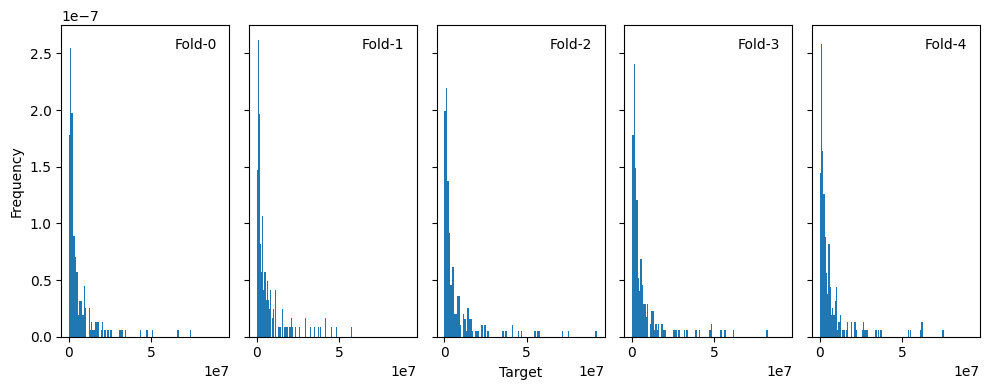

In [7]:
full_train = pd.concat([X_train,y_train],axis=1)

fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4))
for i, ax in enumerate(axs):
    ax.hist(full_train[full_train.Fold == i]['SiteEnergyUseWN(kBtu)'], bins=100, density=True, label=f'Fold-{i}')
    if i == 0:
        ax.set_ylabel('Frequency')
    if i == 2:
        ax.set_xlabel("Target")
    ax.legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

## Evaluation des modèles

On va maintenant tester différents modèles d'apprentissage sur notre jeu de données avec les Folds qu'on a créé pour déterminer le plus efficace sur notre problème. Pour cela, on va commencer par faire un premier test en utilisant les paramètres par défaut pour chaque modèle et on va s'intéresser aux résultats obtenus. Pour évaluer ces résultats on peut faire appel à 3 scores différents, le R2, la RMSE et la MAE, qui vont nous permettre de comparer les différents algorithmes.

In [8]:
#Une fonction pour récupérer les index sur le StratifiedKFold et créer une cross validation stratifiée
def custom_strat_kfold(df):
    test_index = np.empty([5],dtype='object')
    train_index = np.empty([5],dtype='object')
    for i in range(5) : 
        index = df.loc[df['Fold']==i].index.tolist()
        test_index[i] = index
    
    for i in range(5):
        train_index[i] = [x for x in df.index if x not in test_index[i]]
        
    return(list(zip(train_index,test_index)))

#Une fonction pour calculer différents scores pour évaluer les modèles
def folded_scores(model):
    print(model)
    model_scores = pd.DataFrame(cross_validate(model,X_train,y_train,cv=custom_cv,
                    scoring=('r2','neg_root_mean_squared_error','neg_mean_absolute_error')))
    display(model_scores)
    
    R2 = model_scores['test_r2'].mean()
    RMSE = model_scores['test_neg_root_mean_squared_error'].mean()
    MAE = model_scores['test_neg_mean_absolute_error'].mean()
    
    
    model_mean = pd.DataFrame([[R2,RMSE,MAE]], columns = ['R2','RMSE','MAE'])
    display(model_mean)
    return(model_mean)


### Dummy Regressor

Notre premier modèle sera un Dummy Reggressor, c'est-à-dire un modèle assez naïf qui donnera uniquement une valeur statistique assez basique comme la médiane ou la moyenne des valeurs. Ça sera évidemment une estimation assez éloignée de la réalité, mais cela nous donne une première idée et un bon point de comparaison pour la suite.



In [9]:
#On crée une cross validation en prenant les index du stratified KFold
custom_cv = custom_strat_kfold(X_train)
#On retire maintenant les variables Fold et Bins qui ne nous servent plus
X_train.drop(['Fold','Bins'],axis=1,inplace=True)

dummy = DummyRegressor(strategy='mean')

dummy_mean = folded_scores(dummy)
dummy_mean.index = (['Dummy Mean'])

DummyRegressor()


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.002000,0.001000,-0.001627,-1.057958e+07,-6.645596e+06
1,0.002001,0.000000,-0.003492,-9.528416e+06,-6.458705e+06
2,0.003001,0.000000,-0.003611,-1.330694e+07,-7.417798e+06
3,0.002000,0.001001,-0.000499,-1.182524e+07,-7.014003e+06
4,0.000999,0.001000,-0.000039,-1.158203e+07,-6.835186e+06


,R2,RMSE,MAE
0,-0.001854,-1.136444e+07,-6.874258e+06


Le score du R-squared est idéal à 1, on voit donc qu'avec notre score de 0 notre estimateur est très loin de notre objectif, mais cela nous donne un premier aperçu.

In [10]:
dummy = DummyRegressor(strategy='median')

dummy_median = folded_scores(dummy)
dummy_median.index = (['Dummy Median'])

DummyRegressor(strategy='median')


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.002001,0.001,-0.134335,-1.125865e+07,-5.354279e+06
1,0.002000,0.001,-0.158363,-1.023731e+07,-5.209742e+06
2,0.002001,0.000,-0.135046,-1.415149e+07,-6.278676e+06
3,0.002001,0.001,-0.142445,-1.263628e+07,-5.849397e+06
4,0.003000,0.000,-0.130074,-1.231203e+07,-5.585257e+06


,R2,RMSE,MAE
0,-0.140053,-1.211915e+07,-5.655470e+06


### Régressions linéaires

On va maintenant commencer à travailler avec des algorithmes plus réfléchis. Tout d'abord on va essayer quelques algorithmes de régression linéaire tel que Ridge, Lasso et Elastic Net.

#### Ridge 

In [11]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state =10)

ridge_mean = folded_scores(ridge)
ridge_mean.index = (['Ridge'])

Ridge(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.004001,0.002000,0.728169,-5.511441e+06,-3.379495e+06
1,0.003000,0.002001,0.624544,-5.828318e+06,-3.225216e+06
2,0.003001,0.002000,0.768154,-6.395808e+06,-3.427245e+06
3,0.004001,0.002001,0.764641,-5.735440e+06,-3.041548e+06
4,0.003000,0.001000,0.449848,-8.590483e+06,-3.835442e+06


,R2,RMSE,MAE
0,0.667071,-6.412298e+06,-3.381789e+06


#### Lasso

In [12]:
from sklearn.linear_model import Lasso

lasso = Lasso(random_state =10)

lasso_mean = folded_scores(lasso)
lasso_mean.index = (['Lasso'])

Lasso(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.058013,0.002001,0.732926,-5.462996e+06,-3.368982e+06
1,0.059013,0.001001,0.636842,-5.732073e+06,-3.213316e+06
2,0.057327,0.001001,0.768695,-6.388343e+06,-3.435280e+06
3,0.057030,0.001000,0.738861,-6.041398e+06,-3.114175e+06
4,0.057013,0.002000,0.446074,-8.619896e+06,-3.875718e+06


,R2,RMSE,MAE
0,0.66468,-6.448941e+06,-3.401494e+06


#### Elastic Net

In [13]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(random_state =10)

elastic_mean = folded_scores(elastic)
elastic_mean.index = (['Elastic'])

ElasticNet(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.005001,0.002001,0.559882,-7.012939e+06,-4.089314e+06
1,0.004001,0.002000,0.482885,-6.840019e+06,-3.998596e+06
2,0.006003,0.001000,0.656352,-7.786682e+06,-4.281785e+06
3,0.005000,0.002002,0.705801,-6.412429e+06,-3.620842e+06
4,0.005000,0.001001,0.458614,-8.521765e+06,-4.180493e+06


,R2,RMSE,MAE
0,0.572707,-7.314767e+06,-4.034206e+06


On obtient grâce à ces algorithmes des résultats bien meilleurs qu'avant. La meilleure estimation est obtenue pour l'instant par Ridge à peu de chose près, qui obtient des meilleurs résultats sur chaque score.


### Neural Network


In [14]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(random_state =10)

MLP_mean = folded_scores(MLP)
MLP_mean.index = (['Neural Network'])

MLPRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.527119,0.002001,-0.401831,-1.251593e+07,-6.701372e+06
1,0.535122,0.002000,-0.480310,-1.157284e+07,-6.592387e+06
2,0.505114,0.001000,-0.334315,-1.534351e+07,-7.680852e+06
3,0.488110,0.002001,-0.376377,-1.386981e+07,-7.253557e+06
4,0.555125,0.002000,-0.363607,-1.352448e+07,-6.984233e+06


,R2,RMSE,MAE
0,-0.391288,-1.336531e+07,-7.042480e+06


Le résultat obtenu pour cette régression non linéaire est assez mauvais. Tous les scores obtenus sont mauvais et même pires que ceux du Dummy.

### Boosting

On va maintenant regarder des algorithmes de Boosting comme GradientBoosting, LightGBM ou encore XGBoost.

#### Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(random_state =10)

GBR_mean = folded_scores(GBR)
GBR_mean.index = (['Gradient Boosting'])

GradientBoostingRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.236053,0.002001,0.792583,-4.814349e+06,-2.720214e+06
1,0.212048,0.002000,0.670518,-5.459832e+06,-2.849737e+06
2,0.231052,0.003001,0.741820,-6.749270e+06,-3.467885e+06
3,0.178040,0.002000,0.793892,-5.367218e+06,-2.918774e+06
4,0.164037,0.002001,0.519797,-8.025803e+06,-3.600302e+06


,R2,RMSE,MAE
0,0.703722,-6.083294e+06,-3.111382e+06


#### XG Boost

In [16]:
import xgboost as xgb
from sklearn.metrics import r2_score

xg_reg = xgb.XGBRegressor(random_state =10)

xgb_mean = folded_scores(xg_reg)
xgb_mean.index = (['XGBoosting'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=10, ...)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.101022,0.004001,0.755182,-5.230430e+06,-2.876782e+06
1,0.086020,0.003001,0.617579,-5.882129e+06,-2.943163e+06
2,0.084019,0.003000,0.711512,-7.134435e+06,-3.425843e+06
3,0.081018,0.003000,0.798249,-5.310186e+06,-2.949067e+06
4,0.078018,0.004001,0.442907,-8.644500e+06,-3.882060e+06


,R2,RMSE,MAE
0,0.665086,-6.440336e+06,-3.215383e+06


#### LightGBM

In [17]:
import lightgbm as lgb

gbm = lgb.LGBMRegressor(random_state =10)


gbm_mean = folded_scores(gbm)
gbm_mean.index = (['Light GBM'])

LGBMRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.074017,0.002000,0.751469,-5.269942e+06,-3.206194e+06
1,0.057014,0.001000,0.550112,-6.379927e+06,-3.401132e+06
2,0.056012,0.002001,0.625444,-8.129317e+06,-4.020969e+06
3,0.059013,0.001000,0.738414,-6.046567e+06,-3.393821e+06
4,0.066015,0.001000,0.386947,-9.068287e+06,-4.308176e+06


,R2,RMSE,MAE
0,0.610477,-6.978808e+06,-3.666058e+06


Les résultats obtenus sont très bons, et font même largement parti des meilleurs.


### Bagging

#### Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(random_state =10)

RFR_mean = folded_scores(RFR)
RFR_mean.index = (['Random Forest'])

RandomForestRegressor(random_state=10)


,fit_time,score_time,test_r2,test_neg_root_mean_squared_error,test_neg_mean_absolute_error
0,0.543124,0.008001,0.760969,-5.168244e+06,-2.848827e+06
1,0.510116,0.009002,0.599932,-6.016313e+06,-3.004008e+06
2,0.506115,0.008001,0.707989,-7.177868e+06,-3.579867e+06
3,0.774174,0.014003,0.803198,-5.244643e+06,-2.841530e+06
4,0.905205,0.011003,0.498094,-8.205167e+06,-3.615390e+06


,R2,RMSE,MAE
0,0.674036,-6.362447e+06,-3.177925e+06


Rassemblons nos données dans un dataset afin de mieux les visualiser et les comparer.

In [19]:
results = pd.concat([dummy_mean,dummy_median,ridge_mean,lasso_mean,elastic_mean,MLP_mean,GBR_mean,xgb_mean,gbm_mean,RFR_mean])
results

,R2,RMSE,MAE
Dummy Mean,-0.001854,-1.136444e+07,-6.874258e+06
Dummy Median,-0.140053,-1.211915e+07,-5.655470e+06
Ridge,0.667071,-6.412298e+06,-3.381789e+06
Lasso,0.664680,-6.448941e+06,-3.401494e+06
Elastic,0.572707,-7.314767e+06,-4.034206e+06
Neural Network,-0.391288,-1.336531e+07,-7.042480e+06
Gradient Boosting,0.703722,-6.083294e+06,-3.111382e+06
XGBoosting,0.665086,-6.440336e+06,-3.215383e+06
Light GBM,0.610477,-6.978808e+06,-3.666058e+06
Random Forest,0.674036,-6.362447e+06,-3.177925e+06


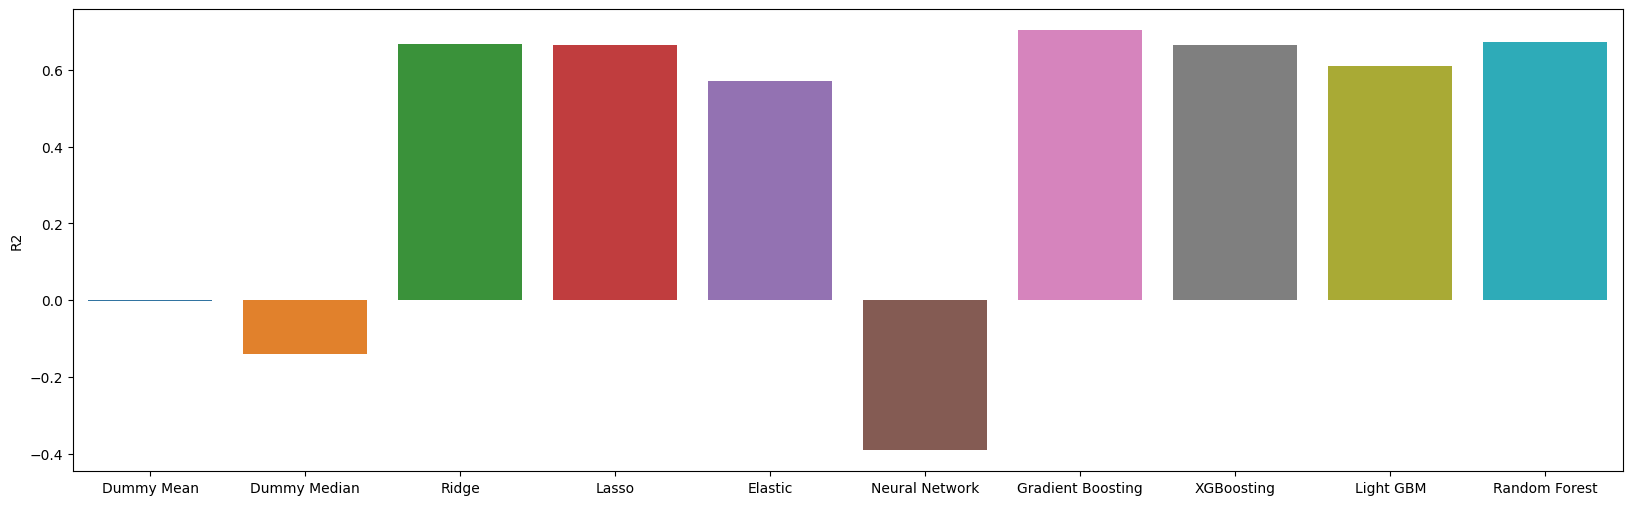

In [20]:
#Affichons ces scores avec un graphique pour les comparer plus facilement
plt.figure(figsize = (20,6))
sns.barplot(data=results,x=results.index,y=results['R2'])
plt.show()

On se concentre sur le R2 car c'est le score sur lequel on va se baser pour notre parameter tuning mais les autres scores concordent également globalement sur les résultats.

Nos modèles les plus efficaces sont Ridge, Gradient Boosting, XG Boost et Random Forest d'après nos résultats. Certains modèles ont des scores meilleurs sur certains scorers, mais dans l'ensemble ce sont les plus réguliers et ça sera donc sur eux qu'on va se concentrer pour la suite.

On va maintenant chercher à améliorer la précision de ces algorithmes en modifiant leurs paramètres à l'aide d'une validation croisée. On sait cependant que nos différents scores ne vont pas forcément varier de la même façon en fonction des paramètres que l'on modifie, on va donc choisir le R-squared comme évaluation principale qu'on va vouloir améliorer. 

## Optimisation des hyperparamètres

Maintenant qu'on a pu déterminer nos modèles les plus efficaces sur des paramètres de bases, on va maintenant aller affiner les modèles ayant obtenu les meilleurs scores en modifiant leurs hyperparamètres pour obtenir des prédictions encore plus précises. Pour cela on va utiliser des algorithmes de validation croisée tels que GridSearch, BayesSearch et RandomSearch. Ces 3 algorithmes ont tous leurs avantages et inconvénients, je vais donc utiliser les 3 en fonction des situations et des résultats obtenus.
 
 En effet, GridSearch va essayer toutes les combinaisons de paramètres dans un espace donné, ce qui fait qu'il peut être lent mais il trouvera la meilleure solution possible sur les paramètres donnés. D'autre part, RandomSearch va lui tester de nombreuses combinaisons de paramètres donnés de façon aléatoire, il prendra donc moins de temps car il ne passe pas sur toutes les combinaisons, mais il peut ne pas trouver le meilleur score. Au contraire, BayesSearch va effectuer des calculs sur chaque jeu de paramètres afin d'affiner la recherche au fur et à mesure. On peut augmenter la précision en augmentant le nombre d'itérations, au prix de la performance. Ainsi, la BayesSearch peut être très longue si on rend trop d'itérations, alors que RandomSearch sera bien plus efficace, sans forcément trop de différences sur les résultats.

###  Optimisation Ridge

In [21]:
#Paramètres de base du modèle
display(ridge.get_params())

#Scores avec les paramètres de base
display(ridge_mean)

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': 10,
 'solver': 'auto',
 'tol': 0.0001}

,R2,RMSE,MAE
Ridge,0.667071,-6.412298e+06,-3.381789e+06


In [22]:
opt =  BayesSearchCV(
     ridge,{'alpha': Real(0.01,5,prior='log-uniform'),
                  'solver' : ['auto','svd','cholesky','sag'],
                'fit_intercept' : [True,False]},
     cv = custom_cv,
     n_iter=100,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.6671012376315193
OrderedDict([('alpha', 1.178353976310759), ('fit_intercept', True), ('solver', 'cholesky')])


In [23]:
opt =  BayesSearchCV(
     ridge,{'alpha': Real(1.1,1.2,prior='log-uniform'),
                  'solver' : ['cholesky'],
                'fit_intercept' : [True]},
     cv = custom_cv,
     n_iter=30,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

ridge_score = opt.best_score_
ridge_estimator = opt.best_estimator_
ridge_var = opt.cv_results_['std_test_score'].mean()

0.6671012751122763
OrderedDict([('alpha', 1.1851558710556072), ('fit_intercept', True), ('solver', 'cholesky')])


In [24]:
ridge_estimator

Ridge(alpha=1.1851558710556072, random_state=10, solver='cholesky')

### Optimisation Gradient Boosting

In [25]:
#Regardons rapidement les paramètres par défaut
display(GBR.get_params())

#Scores avec les paramètres par défaut
display(GBR_mean)

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 10,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

,R2,RMSE,MAE
Gradient Boosting,0.703722,-6.083294e+06,-3.111382e+06


In [26]:
opt =  BayesSearchCV(
     GBR,{'learning_rate' : Real(0.05,0.2,prior='log-uniform'),
       'n_estimators' :Integer(50,350),
       'max_depth':Integer(5,40),
       'min_samples_split':[1,2,3],
       'min_samples_leaf' : [1,2,3],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=200,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.7044943141164612
OrderedDict([('learning_rate', 0.06944207132580035), ('max_depth', 5), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 1), ('n_estimators', 268), ('random_state', 10)])


In [27]:
opt =  BayesSearchCV(
     GBR,{'learning_rate' : Real(0.06,0.071,prior='log-uniform'),
       'n_estimators' :Integer(260,275),
       'max_depth':Integer(3,5),
       'min_samples_split':[1],
       'min_samples_leaf' : [1],
       'max_features' : ['sqrt'],
         'random_state' : [10]},
     n_iter=50,
    cv = custom_cv,
    n_jobs = -1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

GBR_score = opt.best_score_
GBR_estimator = opt.best_estimator_
GBR_var = opt.cv_results_['std_test_score'].mean()

0.706661504726267
OrderedDict([('learning_rate', 0.07089838258881799), ('max_depth', 3), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 1), ('n_estimators', 271), ('random_state', 10)])


In [28]:
#On affiche l'estimateur avec ses meilleurs paramètres
GBR_estimator

GradientBoostingRegressor(learning_rate=0.07089838258881799,
                          max_features='sqrt', min_samples_split=1,
                          n_estimators=271, random_state=10)

### Optimisation Random Forest

In [29]:
#Paramètres par défaut
display(RFR.get_params())

#Scores avec les paramètres par défaut
display(RFR_mean)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

,R2,RMSE,MAE
Random Forest,0.674036,-6.362447e+06,-3.177925e+06


In [30]:
opt = BayesSearchCV(
     RFR,
     {'n_estimators': Integer(50,500),
      'max_features': ['sqrt'],
      'max_depth': Integer(5,50),
      'min_samples_split': [1,2,3,4,5,6],
      'min_samples_leaf': [1,2,3,4],
      'bootstrap': [False,True],
      'random_state' : [10]},
     n_iter=50,
    n_jobs=-1,
    cv = custom_cv,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.6604839259517661
OrderedDict([('bootstrap', False), ('max_depth', 29), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 1), ('n_estimators', 405), ('random_state', 10)])


In [31]:
opt = BayesSearchCV(
     RFR,
     {'n_estimators': Integer(400,410),
      'max_features': ['sqrt'],
      'max_depth': Integer(27,31),
      'min_samples_split': [1],
      'min_samples_leaf': [1],
      'bootstrap': [False],
      'random_state' : [10]},
     n_iter=40,
    cv = custom_cv,
    n_jobs=-1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)


RFR_score = opt.best_score_
RFR_estimator = opt.best_estimator_
RFR_var = opt.cv_results_['std_test_score'].mean()

0.6606667124857815
OrderedDict([('bootstrap', False), ('max_depth', 29), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 1), ('n_estimators', 402), ('random_state', 10)])


In [32]:
#On affiche l'estimateur avec ses meilleurs paramètres
RFR_estimator

RandomForestRegressor(bootstrap=False, max_depth=29, max_features='sqrt',
                      min_samples_split=1, n_estimators=402, random_state=10)

### Optimisation XGBoost

In [33]:
#Paramètres par défaut
display(xg_reg.get_params())

#Scores avec paramètres par défaut
display(xgb_mean)

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 10,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

,R2,RMSE,MAE
XGBoosting,0.665086,-6.440336e+06,-3.215383e+06


In [34]:
opt = BayesSearchCV(
     xg_reg,
     {'eta': Real(0.001,0.5,prior='log-uniform'),
      'min_child_weight': Integer(1,20),
      'max_depth': Integer(1,50),
      'gamma': Integer(0,40),
      'random_state' : [10]},
     n_iter=100,
    cv = custom_cv,
    n_jobs=-1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)


0.7137773084033215
OrderedDict([('eta', 0.34837553412801775), ('gamma', 0), ('max_depth', 4), ('min_child_weight', 1), ('random_state', 10)])


In [35]:
opt = BayesSearchCV(
     xg_reg,
     {'eta': Real(0.1,0.2,prior='log-uniform'),
      'min_child_weight': Integer(1,5),
      'max_depth': Integer(2,5),
      'gamma': Integer(38,50),
      'random_state' : [10]},
     n_iter=50,
    cv = custom_cv,
    n_jobs=-1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

0.7217096035032649
OrderedDict([('eta', 0.1), ('gamma', 50), ('max_depth', 4), ('min_child_weight', 1), ('random_state', 10)])


In [36]:
opt = BayesSearchCV(
     xg_reg,
     {'eta': Real(0.05,0.1,prior='log-uniform'),
      'min_child_weight': [1,2],
      'max_depth': [4,5],
      'gamma': Integer(48,55),
      'random_state' : [10]},
     n_iter=50,
    cv = custom_cv,
    n_jobs=-1,
     random_state=10
 )

opt.fit(X_train, y_train)
print(opt.best_score_)
print(opt.best_params_)

XGB_score = opt.best_score_
XGB_estimator = opt.best_estimator_
XGB_var = opt.cv_results_['std_test_score'].mean()

0.7217096035032649
OrderedDict([('eta', 0.1), ('gamma', 54), ('max_depth', 4), ('min_child_weight', 1), ('random_state', 10)])


In [37]:
#On affiche l'estimateur avec ses meilleurs paramètres
XGB_estimator

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=54, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

Maintenant qu'on a obtenu les meilleurs scores possibles pour chaque modèle, compilons toutes ces informations afin de les comparer plus facilement. Pour chaque modèle, on affichera les scores R2, RMSE et MAE sur la cross validation, ainsi que sur l'échantillon de test. On ajoutera également pour le R2 l'écart type afin d'observer la marge d'erreur.

In [38]:
X_test.drop('Bins',axis=1, inplace=True)

ridge_estimator.fit(X_train,y_train)
GBR_estimator.fit(X_train,y_train)
RFR_estimator.fit(X_train,y_train)
XGB_estimator.fit(X_train,y_train)

ridge_cv_scores = cross_validate(ridge_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)
GBR_cv_scores = cross_validate(GBR_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)
RFR_cv_scores = cross_validate(RFR_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)
XGB_cv_scores = cross_validate(XGB_estimator,X_train,y_train,scoring=['neg_root_mean_squared_error','neg_mean_absolute_error'],cv=custom_cv)


CV_R2_scores = pd.DataFrame([ridge_score,GBR_score,RFR_score,XGB_score])
CV_RMSE_scores = pd.DataFrame([ridge_cv_scores['test_neg_root_mean_squared_error'].mean(),GBR_cv_scores['test_neg_root_mean_squared_error'].mean(),RFR_cv_scores['test_neg_root_mean_squared_error'].mean(),XGB_cv_scores['test_neg_root_mean_squared_error'].mean()])
CV_MAE_scores = pd.DataFrame([ridge_cv_scores['test_neg_mean_absolute_error'].mean(),GBR_cv_scores['test_neg_mean_absolute_error'].mean(),RFR_cv_scores['test_neg_mean_absolute_error'].mean(),XGB_cv_scores['test_neg_mean_absolute_error'].mean()])


test_R2_scores = pd.DataFrame([ridge_estimator.score(X_test,y_test),GBR_estimator.score(X_test,y_test),RFR_estimator.score(X_test,y_test),XGB_estimator.score(X_test,y_test)])
test_RMSE_scores = pd.DataFrame(np.sqrt([mean_squared_error(y_test,ridge_estimator.predict(X_test)),mean_squared_error(y_test,GBR_estimator.predict(X_test)),mean_squared_error(y_test,RFR_estimator.predict(X_test)),mean_squared_error(y_test,XGB_estimator.predict(X_test))]))
test_MAE_scores = pd.DataFrame([mean_absolute_error(y_test,ridge_estimator.predict(X_test)),mean_absolute_error(y_test,GBR_estimator.predict(X_test)),-mean_absolute_error(y_test,RFR_estimator.predict(X_test)),mean_absolute_error(y_test,XGB_estimator.predict(X_test))])

CV_var = pd.DataFrame([ridge_var,GBR_var,RFR_var,XGB_var])
scores = pd.concat([CV_R2_scores,CV_var,-1*CV_RMSE_scores,-1*CV_MAE_scores,test_R2_scores,test_RMSE_scores,test_MAE_scores],axis=1)

scores.index = ['Ridge','Gradient Boosting','Random Forest','XGBoost']
scores.columns = ['CV R2','Erreur R2','CV RMSE','CV MAE','Test R2 Scores','Test RMSE Score','Test MAE Scores']
scores

,CV R2,Erreur R2,CV RMSE,CV MAE,Test R2 Scores,Test RMSE Score,Test MAE Scores
Ridge,0.667101,0.120568,6.410517e+06,3.379610e+06,0.645974,5.922696e+06,3.224794e+06
Gradient Boosting,0.706662,0.091043,6.040775e+06,3.156413e+06,0.682062,5.612717e+06,3.087953e+06
Random Forest,0.660667,0.080897,6.558533e+06,3.326620e+06,0.660134,5.803046e+06,-3.103843e+06
XGBoost,0.721710,0.113427,5.866128e+06,3.017105e+06,0.687329,5.566033e+06,2.884868e+06


Le modèle qui obtient les meilleurs résultats est donc XGBoost, c'est donc cet algorithme qu'on retient pour notre projet.

## Analyse des erreurs

On peut s'intéresser aux erreurs de notre estimateur afin de les comprendre et de voir les limites du modèle.
En regardant les erreurs de prédiction sur la cross validation, j'ai pu détecter des erreurs dans mon tri et également identifier ce qui pouvait poser problème à mes estimateurs afin d'en améliorer les performances.

Suite à cela, on peut maintenant regarder les erreurs que l'estimateur choisi fait sur l'échantillon de test, afin de se rendre compte des erreurs qui subsistent. On peut également regarder les quelques lignes où les erreurs sont importantes via SHAP avec un forceplot afin d'essayer de comprendre d'où vient l'erreur (voir plus bas).

In [39]:
#On calcule les prédictions avec l'estimateur
XGB_estimator.fit(X_train,y_train)
predictions  = pd.DataFrame(XGB_estimator.predict(X_test))
predictions.index = y_test.index

#On crée un dataset comprenant les prédictions et les valeurs réelles
data = pd.concat([predictions,y_test],axis=1)
data.rename({0:'Predictions'},axis=1,inplace=True)
data

,Predictions,SiteEnergyUseWN(kBtu)
189,6404421.00,9.403592e+05
471,6750212.50,3.714717e+06
1101,4159853.50,2.053325e+06
679,2502344.25,5.211180e+06
1402,1400393.00,9.844836e+06
...,...,...
35,4511734.50,2.331573e+06
1074,2015138.50,6.129780e+06
285,31459750.00,2.490323e+07
818,6431082.00,7.429423e+06


In [40]:
#On calcule les pourcentages d'erreur entre nos deux colonnes
data['Error'] = data['SiteEnergyUseWN(kBtu)'] - data['Predictions'] 
data['Error%'] = data['Error']/data['SiteEnergyUseWN(kBtu)']*100

In [41]:
data

,Predictions,SiteEnergyUseWN(kBtu),Error,Error%
189,6404421.00,9.403592e+05,-5.464062e+06,-581.061140
471,6750212.50,3.714717e+06,-3.035495e+06,-81.715378
1101,4159853.50,2.053325e+06,-2.106528e+06,-102.591065
679,2502344.25,5.211180e+06,2.708835e+06,51.981231
1402,1400393.00,9.844836e+06,8.444443e+06,85.775355
...,...,...,...,...
35,4511734.50,2.331573e+06,-2.180161e+06,-93.506016
1074,2015138.50,6.129780e+06,4.114642e+06,67.125435
285,31459750.00,2.490323e+07,-6.556522e+06,-26.328001
818,6431082.00,7.429423e+06,9.983410e+05,13.437665


<AxesSubplot: xlabel='Predictions', ylabel='SiteEnergyUseWN(kBtu)'>

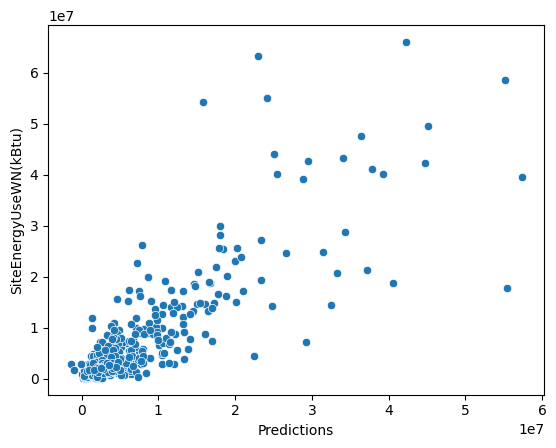

In [42]:
sns.scatterplot(data,x='Predictions',y='SiteEnergyUseWN(kBtu)')

<AxesSubplot: xlabel='Error%', ylabel='Count'>

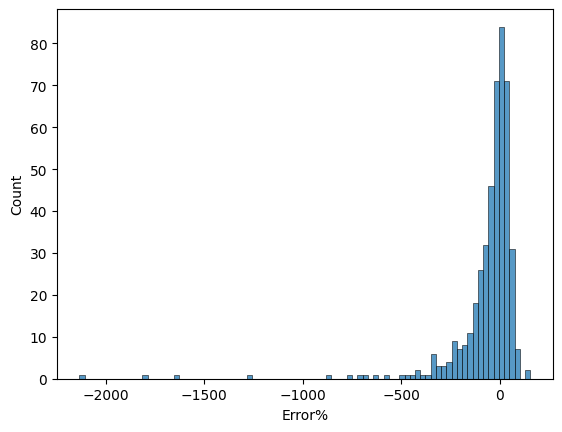

In [43]:
sns.histplot(data,x='Error%' )

In [44]:
data.loc[abs(data['Error%'])>500]

,Predictions,SiteEnergyUseWN(kBtu),Error,Error%
189,6404421.000,9.403592e+05,-5.464062e+06,-581.061140
1397,8382870.500,1.056508e+06,-7.326363e+06,-693.450924
688,1755351.125,1.283839e+05,-1.626967e+06,-1267.267350
1161,2285459.500,1.206105e+05,-2.164849e+06,-1794.909233
257,5587055.500,7.758642e+05,-4.811191e+06,-620.107409
674,2555074.000,2.671351e+05,-2.287939e+06,-856.472609
535,5085093.500,6.221857e+05,-4.462908e+06,-717.295158
522,2626958.750,1.517543e+05,-2.475204e+06,-1631.060539
29,7284476.000,3.262231e+05,-6.958253e+06,-2132.973734
1382,1969380.125,2.309889e+05,-1.738391e+06,-752.586454


In [45]:
data.loc[abs(data['Error%'])>500].index

Int64Index([189, 1397, 688, 1161, 257, 674, 535, 522, 29, 1382], dtype='int64')

In [46]:
#On reset les index afin de pouvoir se servir des lignes
X_test.reset_index(inplace=True,drop=True)
data.reset_index(inplace=True,drop=True)

In [47]:
data.loc[abs(data['Error%'])>500].index

Int64Index([0, 94, 105, 154, 300, 356, 357, 375, 379, 439], dtype='int64')

## Feature Importance

Il serait maintenant intéressant de regarder les features importances globales et locales, afin de comprendre un peu mieux les fonctionnements de nos algorithmes, ainsi que nos résultats. Pour cela on va faire appel à la librairie SHAP.

### Sur le Modèle

Regardons tout d'abord les features importances de notre meilleur modèle, afin de mieux comprendre son fonctionnement et les variables qu'il utilise en priorité.

Text(0, 0.5, 'Feature Importance Score')

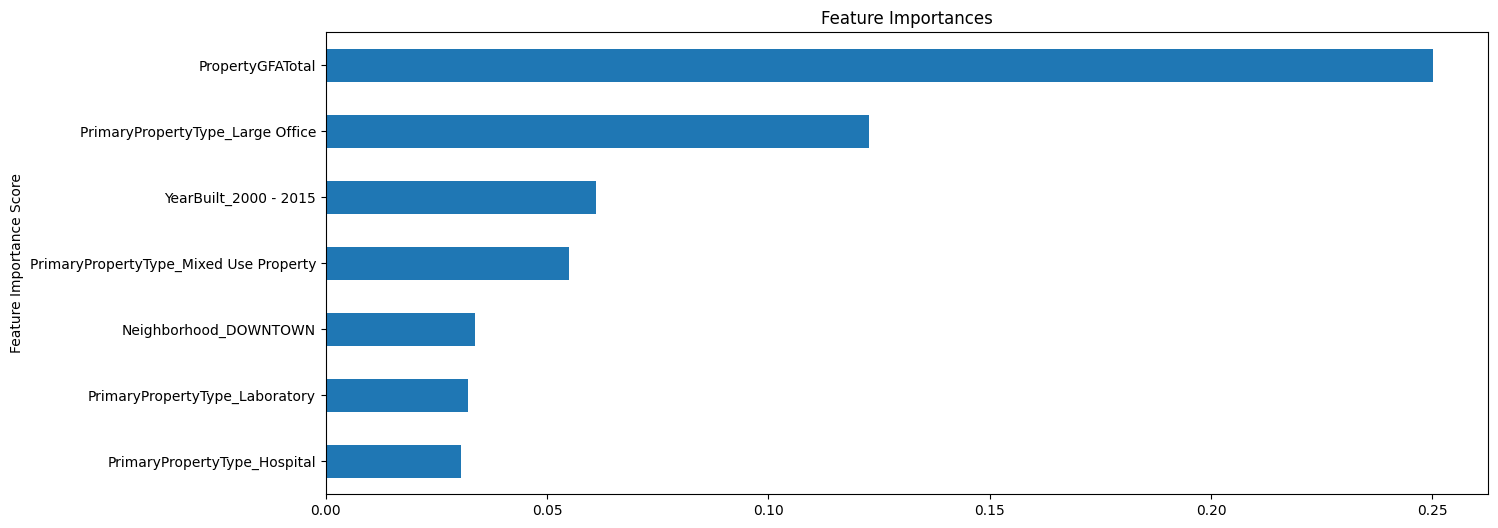

In [48]:
from matplotlib.pyplot import figure
estimator = XGB_estimator

mask = XGB_estimator.feature_importances_> 0.03
figure(figsize=(15,6))
feat_imp = pd.Series(estimator.feature_importances_[mask], X_train.columns[mask]).sort_values(ascending=True)

feat_imp.plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Globale

Regardons maintenant quelques graphs afin de se rendre compte des importances globales, c'est à dire indépendamment du modèle utilisé.

In [49]:
import shap
shap.initjs()

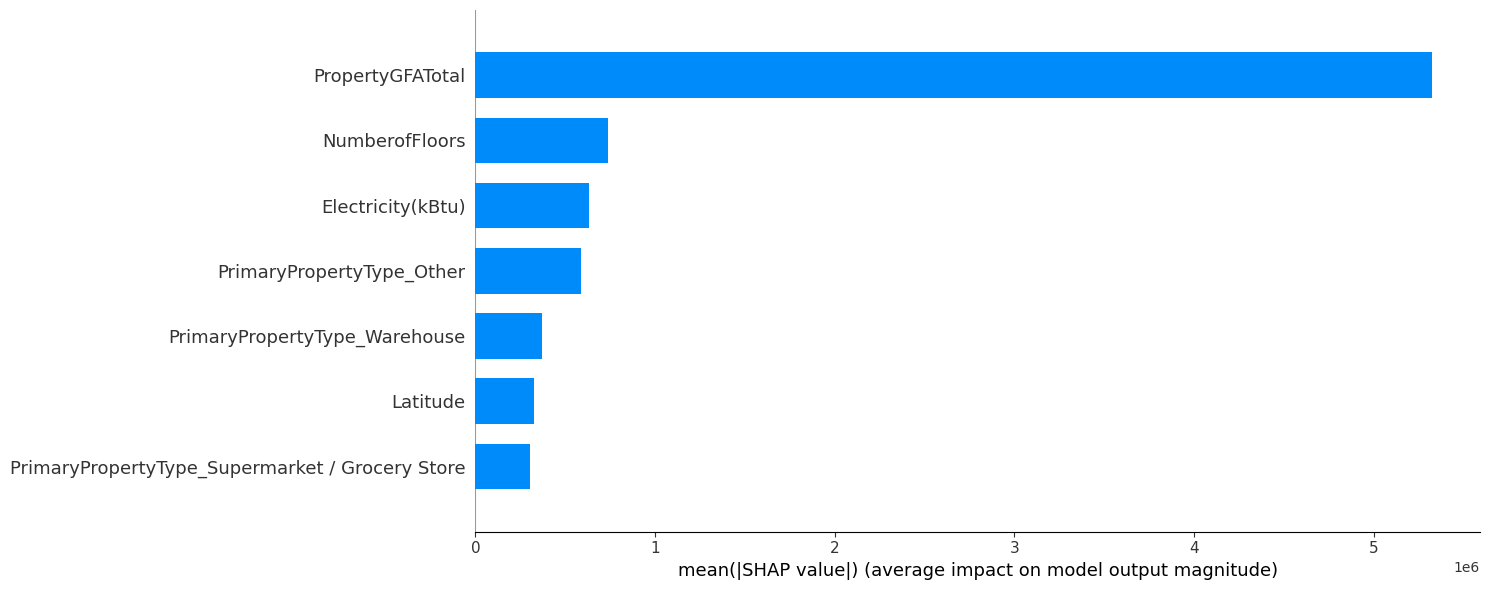

In [50]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,8

XGB_estimator.fit(X_train,y_train)

explainer = shap.TreeExplainer(XGB_estimator,X_train)
shap_values  = explainer.shap_values(X_train,check_additivity=False)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_size = (15,6),plot_type='bar',max_display=7)

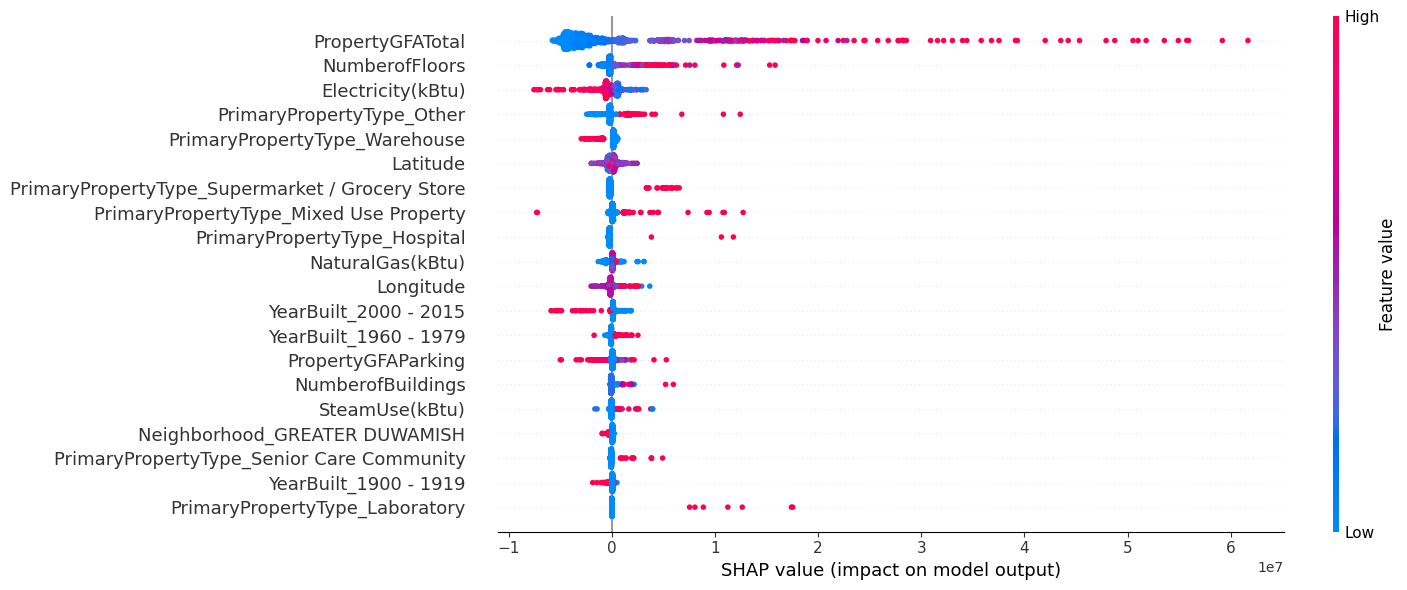

In [51]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_size = (15,6))

### Locale

On peut regarder les importances locales en regardant des points particuliers à l'aide d'un Force Plot. Ici on revient sur des bâtiments dont la prédiction était très éloignée de la valeur réelle pour voir si on peut essayer de comprendre pourquoi.

In [66]:
explainer = shap.TreeExplainer(XGB_estimator,X_train)
shap_values  = explainer.shap_values(X_test,check_additivity=False)

In [53]:
ind = 154
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_train.columns
)

In [54]:
ind = 379
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:],
    feature_names=X_train.columns
)

On peut voir sur ces graphs les influences des différentes variables sur la valeur obtenue ainsi que leurs importances relatives. Il est cependant dur de tirer des conclusions uniquement à partir de cela.

## Energy Star Score

Déterminons maintenant l'influence de l'EnergyStarScore sur nos prédictions. Pour cela, on va utiliser notre estimateur optimal qu'on a obtenu précédemment, voir le résultat obtenu sur la prédiction du set de test, puis on la comparera au résultat obtenu en ajoutant la variable EnergyStarScore dans notre algorithme.

In [55]:
#On sélectionne les données qui nous intéressent en retirant les valeurs manquantes
star_score = ml_data.loc[~ml_data['ENERGYSTARScore'].isna()]
star_score.drop('TotalGHGEmissions',axis=1,inplace=True)

from sklearn.preprocessing import KBinsDiscretizer

#On discrétise ce nouveau dataset comme initialement
discret = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile',random_state=10)
star_score['Bins'] = discret.fit_transform(np.array(star_score['SiteEnergyUseWN(kBtu)']).reshape(-1,1))

In [56]:
#On sépare les colonnes pour isoler la variable cible
y_star, X_star = star_score['SiteEnergyUseWN(kBtu)'], star_score.drop(columns='SiteEnergyUseWN(kBtu)')

#On sépare en train et test avec la stratification
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.3, random_state=10, stratify=X_star['Bins'])

In [57]:
#On crée un échantillon témoin en retirant le score afin de comparer les résultats.
X_temoin_train = X_star_train.drop('ENERGYSTARScore',axis=1)
X_temoin_test = X_star_test.drop('ENERGYSTARScore',axis=1)

X_star_train.drop('Bins',axis=1,inplace=True)
X_star_test.drop('Bins',axis=1,inplace=True)
X_temoin_train.drop('Bins',axis=1,inplace=True)
X_temoin_test.drop('Bins',axis=1,inplace=True)

In [58]:
#On calcule le score sur l'échantillon témoin
XGB_estimator.fit(X_temoin_train,y_star_train)
XGB_estimator.score(X_temoin_test,y_star_test)

0.7716599635227621

In [59]:
#Puis le score sur l'échantillon de test contenant l'ENERGYSTARScore
XGB_estimator.fit(X_star_train,y_star_train)
XGB_estimator.score(X_star_test,y_star_test)

0.825252749252956

On peut voir ici que le résultat sur l'échantillon possédant l'ENERGYSTARScore est sensiblement meilleur, avec une amélioration de 0.05 .